# DiT Recon Visualization

Load reconstructed TSVs from `checkpoints/dit/samples_epochXXX` and visualize. Adjust `epoch`/`num_show` if needed.

Found 2 TSVs under checkpoints/dit\samples_epoch001
G values per sample:
Pair_47_sim_hic_freq_recon: G=0.5999
Pair_5_sim_hic_freq_recon: G=0.6004
Saved visualization to checkpoints/dit\samples_epoch001\recon_vis_001.png


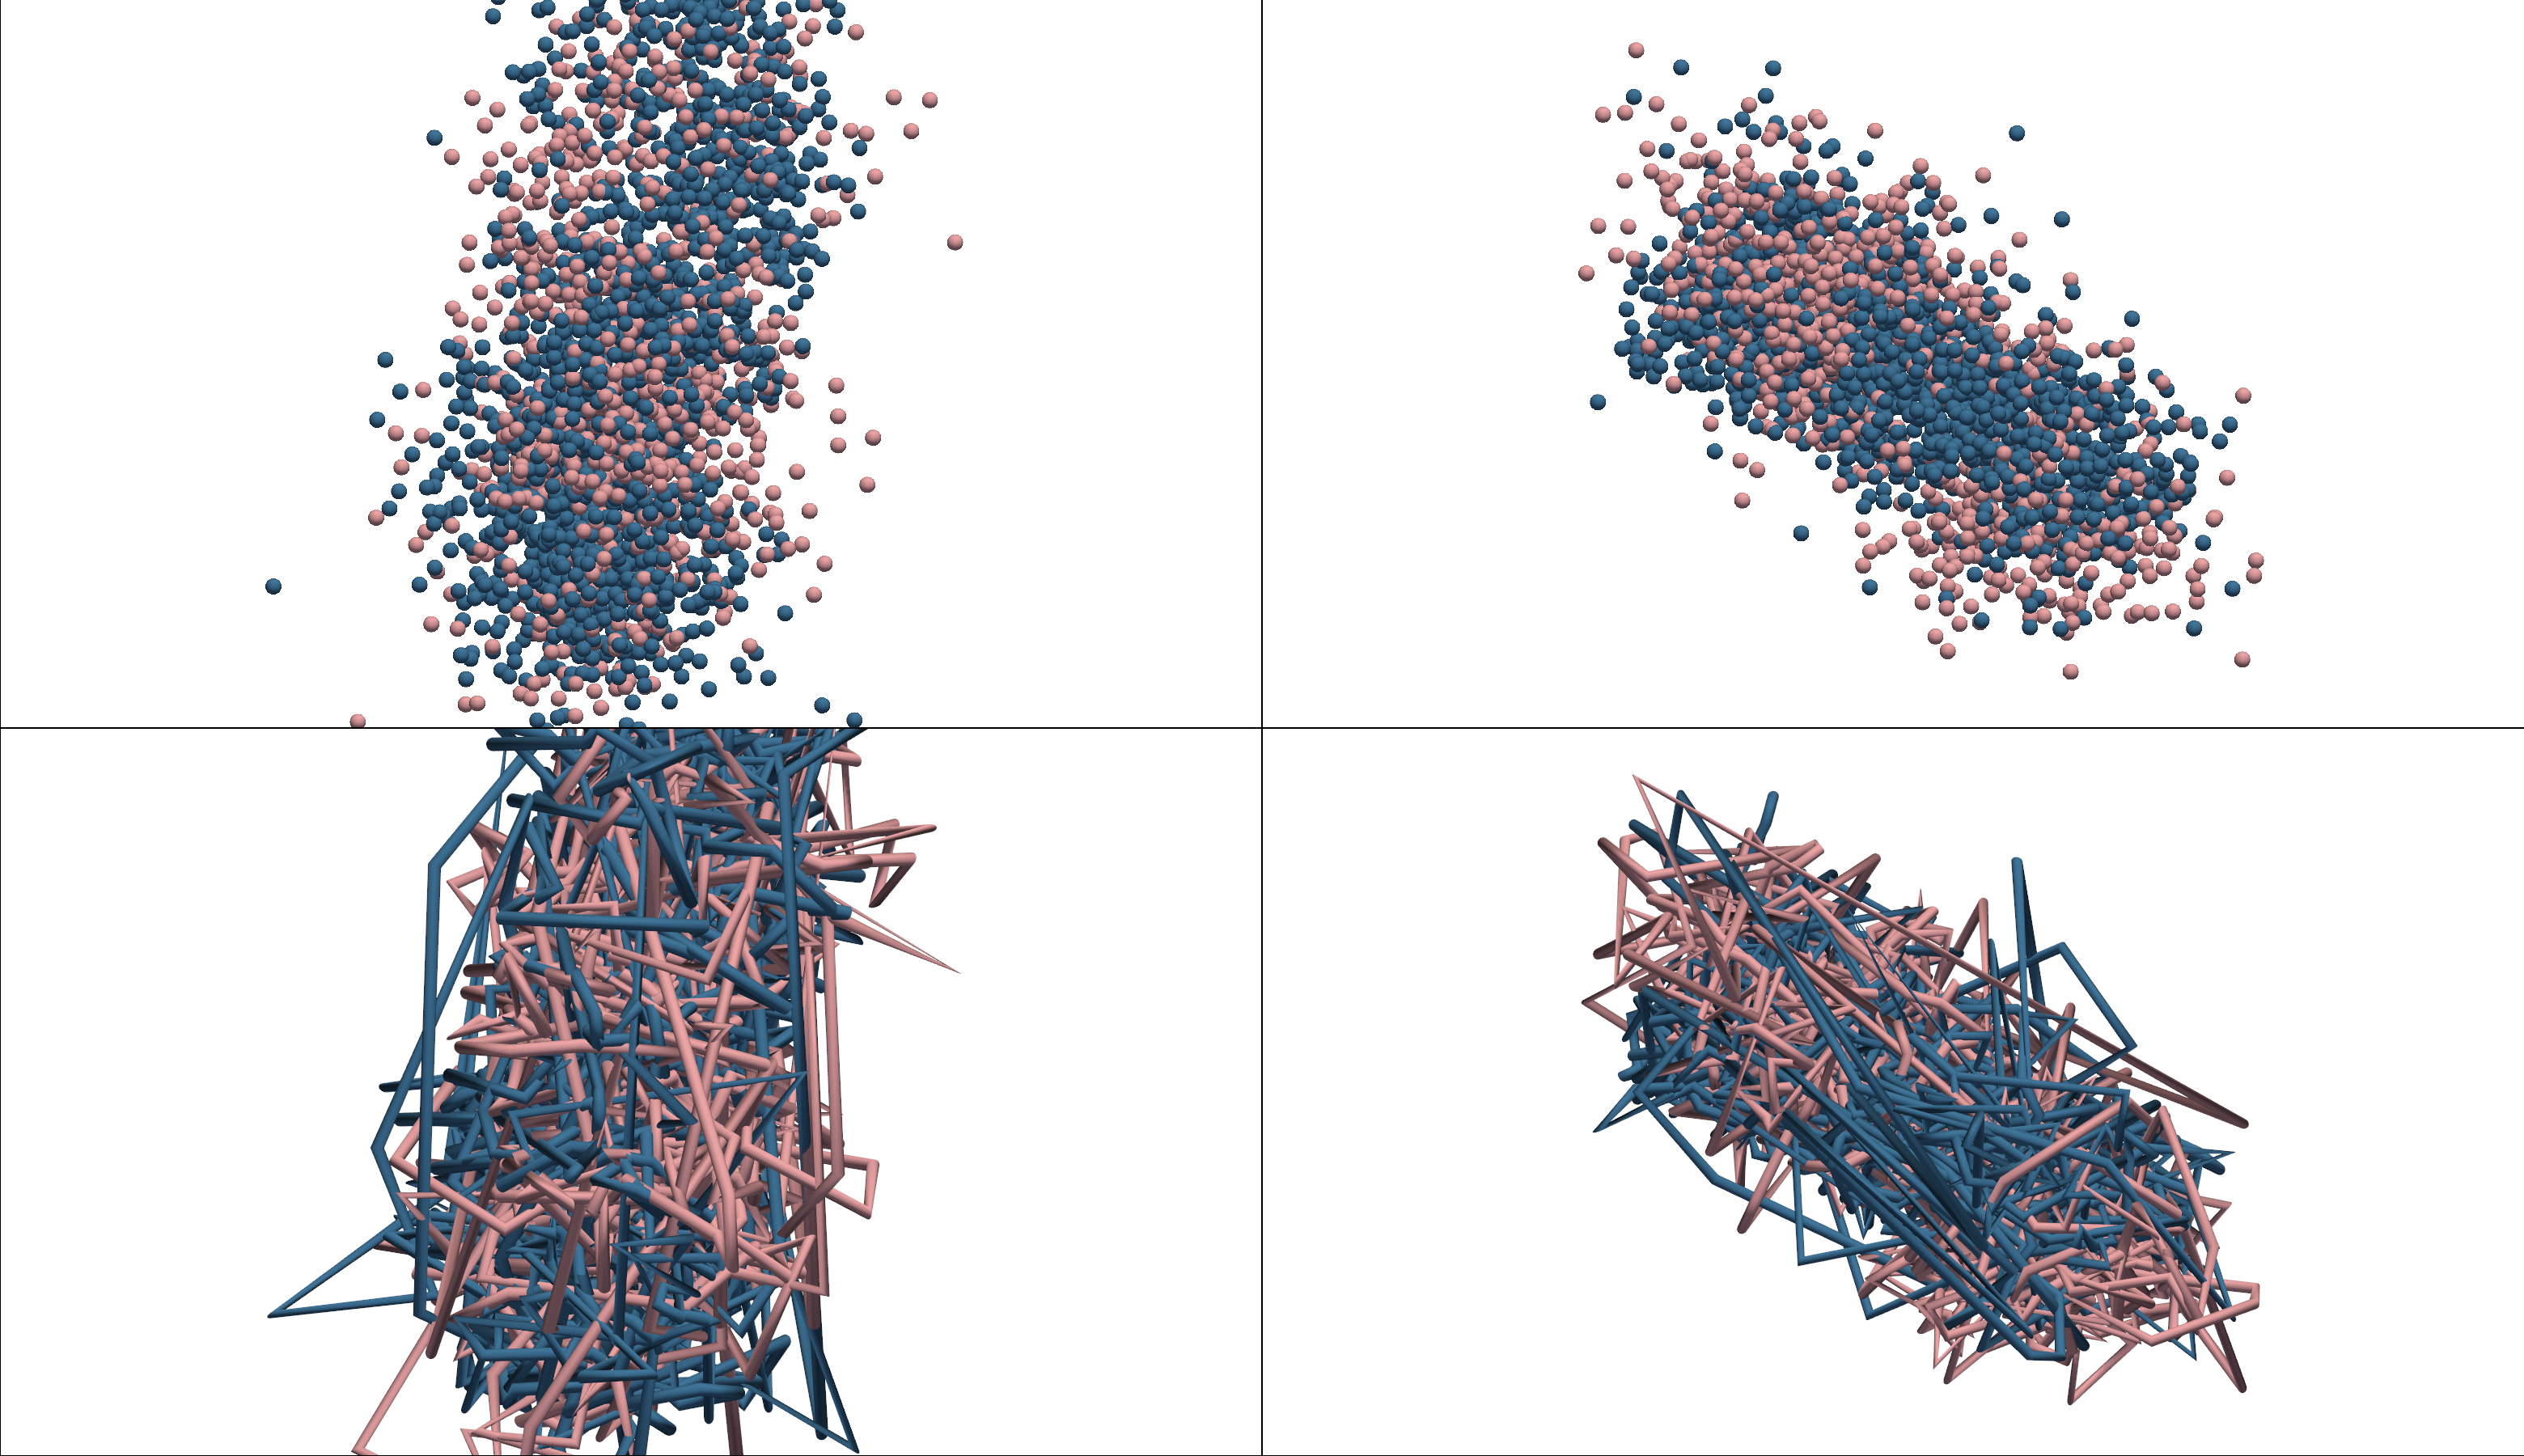

In [ ]:
import os, glob, torch, numpy as np
from IPython.display import Image, display
from models.VAE.visualization import load_struct_tensor, extract_chain_coords, add_polyline

def compute_G(struct_tensor: torch.Tensor):
    chain_orig = ((struct_tensor[...,3]>0.5).sum() + (struct_tensor[...,11]>0.5).sum()).item()
    chain_copy = ((struct_tensor[...,7]>0.5).sum() + (struct_tensor[...,15]>0.5).sum()).item()
    return chain_copy / chain_orig + 1.0

samples_dir = 'checkpoints/dit'  # root dir containing samples_epochXXX folders
epoch = '001'                     # change to desired epoch suffix
num_show = 5                      # number of samples to visualize

tsv_dir = os.path.join(samples_dir, f'samples_epoch{epoch}')
tsv_files = sorted(glob.glob(os.path.join(tsv_dir, '*.tsv')))
print(f'Found {len(tsv_files)} TSVs under {tsv_dir}')
if len(tsv_files) == 0:
    raise SystemExit('No TSV files found')

orig_list, names, G_values = [], [], []
for p in tsv_files:
    struct_tensor, _ = load_struct_tensor(p, torch.device('cpu'))
    orig_list.append(struct_tensor.cpu())
    names.append(os.path.splitext(os.path.basename(p))[0])
    G_values.append(compute_G(struct_tensor.squeeze(0)))

print('G values per sample:')
for n, g in zip(names, G_values):
    print(f'{n}: G={g:.4f}')

orig_cat = torch.cat(orig_list, dim=0)
recon_cat = orig_cat  # same tensors

steel_blue = '#4682B4'
pink_light = '#FFB6C1'
plotter = None

total = orig_cat.size(0)
num_show = min(num_show, total)
sel_idx = torch.randperm(total)[:num_show]
orig_cat = orig_cat[sel_idx]
names_sel = [names[i] for i in sel_idx]

plotter = __import__('pyvista').Plotter(shape=(2, num_show), window_size=(num_show * 520, 600), off_screen=True)

def set_cam(pl, pts, shrink=0.9):
    center = pts.mean(axis=0)
    max_range = np.ptp(pts, axis=0).max()
    max_range = max(max_range, 1e-3)
    offset = max_range * 2.0
    pl.camera.focal_point = center
    pl.camera.position = center + np.array([offset, offset, offset])
    pl.camera.up = (0,0,1)
    pl.camera.parallel_projection = True
    pl.camera.parallel_scale = (max_range * 0.5) * shrink

for i in range(num_show):
    # scatter row
    plotter.subplot(0, i)
    pts_accum = []
    for chain, color in [('orig', steel_blue), ('copy', pink_light)]:
        x, y, z = extract_chain_coords(orig_cat[i], chain)
        if len(x)==0: continue
        pts = np.column_stack((x, y, z))
        pts_accum.append(pts)
        plotter.add_points(pts, color=color, point_size=20, render_points_as_spheres=True)
    if pts_accum: set_cam(plotter, np.concatenate(pts_accum, axis=0))
    plotter.remove_bounds_axes()
    # line row
    plotter.subplot(1, i)
    all_pts = []
    for chain, color in [('orig', steel_blue), ('copy', pink_light)]:
        x, y, z = extract_chain_coords(orig_cat[i], chain)
        if len(x)==0: continue
        pts = np.column_stack((x, y, z))
        all_pts.append(pts)
        add_polyline(plotter, pts, color=color, width=0.3)
    if all_pts: set_cam(plotter, np.concatenate(all_pts, axis=0))
    plotter.remove_bounds_axes()

out_path = os.path.join(tsv_dir, f'recon_vis_{epoch}.png')
os.makedirs(tsv_dir, exist_ok=True)
plotter.screenshot(out_path, scale=3.0)
plotter.close()
print(f'Saved visualization to {out_path}')
display(Image(filename=out_path))
